In [194]:
library(zoo)
library(dplyr)
library("scales")
library(glmnet)
library(caret)
library(randomForest)

In [66]:
#read csv data
df_train_features <- read.csv(file="dengue_features_train.csv")

df_train_labels <- read.csv(file="dengue_labels_train.csv")

df_test_features <- read.csv(file="dengue_features_test.csv")


In [67]:
#drop week_start_date colum

df_train_features$week_start_date <- NULL
df_train_labels$week_start_date <- NULL

#change Kelvin Columns to Celcius
df_train_features$reanalysis_min_air_temp_k <- (df_train_features$reanalysis_min_air_temp_k - 273.15)

df_train_features$reanalysis_max_air_temp_k <- (df_train_features$reanalysis_max_air_temp_k - 273.15)

df_train_features$reanalysis_dew_point_temp_k <- (df_train_features$reanalysis_dew_point_temp_k - 273.15)

df_train_features$reanalysis_air_temp_k <- (df_train_features$reanalysis_air_temp_k - 273.15)

#split the data by city

df_train_features_sj <- subset(df_train_features, subset=city=='sj')
df_train_features_iq <- subset(df_train_features, subset=city=='iq')

df_train_labels_sj <- subset(df_train_labels, subset=city=='sj')
df_train_labels_iq <- subset(df_train_labels, subset=city=='iq')

#drop city column

df_train_features_sj <- dplyr::select(df_train_features_sj, -city)
df_train_features_iq <- dplyr::select(df_train_features_iq, -city)

#fill null values with the mean value of the column
df_train_features_sj = na.aggregate(df_train_features_sj)
df_train_features_iq = na.aggregate(df_train_features_iq)

#drop the correlating features for the San Juan training data
df_train_features_sj <- dplyr::select(df_train_features_sj, -reanalysis_avg_temp_k)
df_train_features_sj <- dplyr::select(df_train_features_sj, -reanalysis_sat_precip_amt_mm)
df_train_features_sj <- dplyr::select(df_train_features_sj, -reanalysis_specific_humidity_g_per_kg)



In [68]:
#scale data in range from 0 to 1
df_train_features_sj <- apply(df_train_features_sj, MARGIN = 2, FUN = function(X) (X - min(X))/diff(range(X)))
df_train_features_iq <- apply(df_train_features_iq, MARGIN = 2, FUN = function(X) (X - min(X))/diff(range(X)))

In [207]:
x <- as.matrix(df_train_features_sj)
y <- as.matrix(as.matrix(df_train_labels_sj[, 4])) 


## 75% of the sample size
smp_size <- floor(0.75 * nrow(x))
smp_size_y <- floor(0.75 * nrow(y))
## set the seed to make your partition reproducible
set.seed(2)
train_ind <- sample(seq_len(nrow(x)), size = smp_size)
train_ind_y <- sample(seq_len(nrow(y)), size = smp_size_y)
 
x_train <- x[train_ind, ]
x_test <- x[-train_ind, ]

y_train <- y[train_ind_y, ]
y_test <- y[-train_ind_y, ]



In [208]:
s <- cbind(x, total_cases = y)

In [209]:
mae <- function(error) return(mean(abs(error)) )

In [210]:
colnames(s)[20] <- "total_cases"

In [211]:
#Predicting values for San Juan

In [223]:
#Randomly shuffle the data
s<-s[sample(nrow(s)),]

score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    ridge_mod = glmnet(trainData[,c(1:(ncol(testData) - 1))], 
                   trainData[, 20], 
                   alpha = 0, 
                   lambda = bestlam)
    ridge_pred = predict(ridge_mod, s = bestlam, newx = testData[,c(1:(ncol(testData) - 1))])
    

    score = score + sqrt(mae(testData[,20] - ridge_pred))
}

print(score/10)

[1] 5.107189


In [166]:
score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    lasso_mod = glmnet(trainData[,c(1:(ncol(testData) - 1))], 
                   trainData[, 20], 
                   alpha = 1, 
                   lambda = bestlam)
    lasso_pred = predict(ridge_mod, s = bestlam, newx = testData[,c(1:(ncol(testData) - 1))])
    

    score = score + sqrt(mae(testData[,20] - lasso_pred))
    
}

print(score/10)

[1] 5.091253


In [167]:
score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    knn_mod= knnreg(trainData[,c(1:(ncol(testData) - 1))],trainData[, 20], k = 5)
    knn_pred = predict(knn_mod, newdata = testData[,c(1:(ncol(testData) - 1))])

    score = score + sqrt(mae(testData[,20] - knn_pred)) 
}
print(score/10)

[1] 4.88884


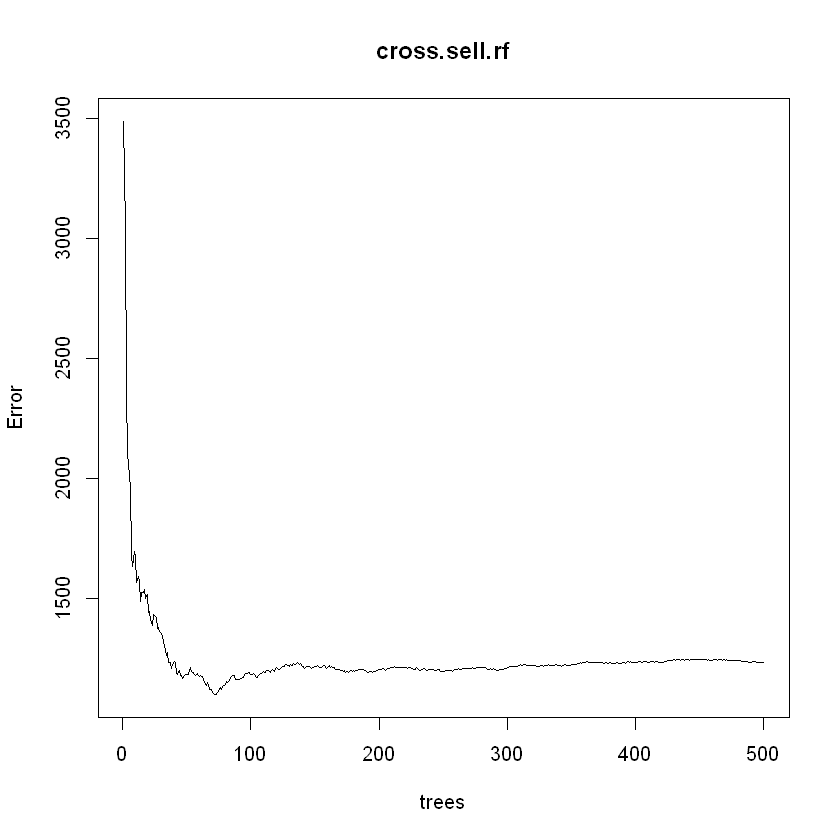

In [177]:
cross.sell.rf <- randomForest(trainData[,c(1:(ncol(testData) - 1))],
                              trainData[, 20],
                              ntree=500,
                              importance=T)
 
plot(cross.sell.rf)

In [193]:
score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    randomForest_mod <- randomForest(trainData[,c(1:(ncol(testData) - 1))],
                              trainData[, 20],
                              ntree=72,
                              importance=T)
    
    randomForest_pred = predict(randomForest_mod, newdata = testData[,c(1:(ncol(testData) - 1))])

    score = score + sqrt(mae(testData[,20] - randomForest_pred)) 
}
print(score/10)



[1] 4.3951


In [ ]:
#Predicting Values for Iquitos

In [247]:
x <- as.matrix(df_train_features_iq)
y <- as.matrix(as.matrix(df_train_labels_iq[, 4])) 


t <- cbind(x, total_cases = y)
colnames(s)[ncol(s)] <- "total_cases"

In [249]:
#Randomly shuffle the data
t<-t[sample(nrow(s)),]

score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(t)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- t[testIndexes, ]
    trainData <- t[-testIndexes, ]
    
    ridge_mod = glmnet(trainData[,c(1:(ncol(testData) - 1))], 
                   trainData[, ncol(trainData)], 
                   alpha = 0, 
                   lambda = bestlam)
    ridge_pred = predict(ridge_mod, s = bestlam, newx = testData[,c(1:(ncol(testData) - 1))])
    

    score = score + sqrt(mae(testData[, ncol(trainData)] - ridge_pred))
}

print(score/10)

[1] 2.526075


In [250]:
score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    lasso_mod = glmnet(trainData[,c(1:(ncol(testData) - 1))], 
                   trainData[,  ncol(trainData)], 
                   alpha = 1, 
                   lambda = bestlam)
    lasso_pred = predict(ridge_mod, s = bestlam, newx = testData[,c(1:(ncol(testData) - 1))])
    

    score = score + sqrt(mae(testData[, ncol(trainData)] - lasso_pred))
    
}

print(score/10)

[1] 2.535558


In [251]:
score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    knn_mod= knnreg(trainData[,c(1:(ncol(testData) - 1))],trainData[,  ncol(trainData)], k = 5)
    knn_pred = predict(knn_mod, newdata = testData[,c(1:(ncol(testData) - 1))])

    score = score + sqrt(mae(testData[, ncol(trainData)] - knn_pred)) 
}
print(score/10)

[1] 2.494677


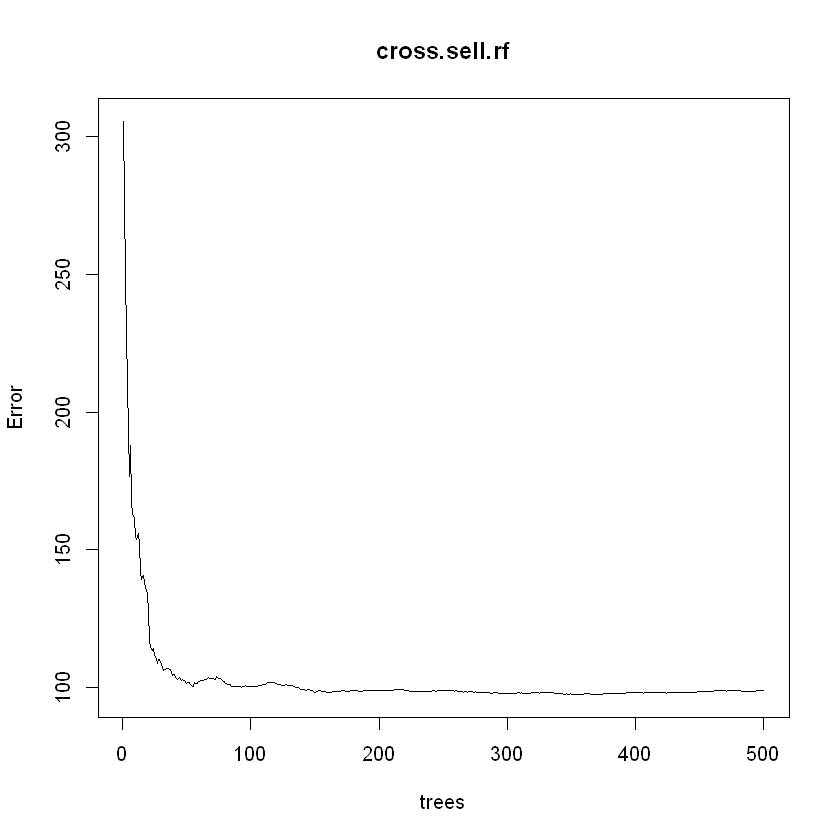

In [252]:
cross.sell.rf <- randomForest(trainData[,c(1:(ncol(testData) - 1))],
                              trainData[,  ncol(trainData)],
                              ntree=500,
                              importance=T)
 
plot(cross.sell.rf)

In [254]:
score = 0
#Create 10 equally size folds
folds <- cut(seq(1,nrow(s)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- s[testIndexes, ]
    trainData <- s[-testIndexes, ]
    
    randomForest_mod <- randomForest(trainData[,c(1:(ncol(testData) - 1))],
                              trainData[,  ncol(trainData)],
                              ntree=120,
                              importance=T)
    
    randomForest_pred = predict(randomForest_mod, newdata = testData[,c(1:(ncol(testData) - 1))])

    score = score + sqrt(mae(testData[, ncol(trainData)] - randomForest_pred)) 
}
print(score/10)



[1] 2.431652
